# **9.1 Camera calibration**

In the previous notebooks we have learnt how 3D points are projected to image pixels through the *camera model*, using **a series of parameters** that do not depend on the position of the 3D points, but on the camera itself, such as the focal length $f$, the principal point coordinates $(u_0,v_0)$ or the position of the camera with respect to the `WORLD` reference system. These parameters are categorized in two sets: 

The **intrinsic parameters** are constant and deal with the camera's internal characteristics. They include:
- its focal length ($f$), 
- the skew ($k_x, k_y$) parameters, 
- and the image center, a.k.a the coordinates of the principal point ($u_0, v_0$). 

In turn, the **extrinsic parameters** may change and describe:
- its position ($\mathbf{t}$) 
- and its orientation ($\mathbf{R}$) in the `WORLD` reference system.

The process of estimating the intrinsic and/or the extrinsic parameters of a vision system is called **camera calibration**. And that is what we are going to accomplish in this notebook.

Apart from this, there is a process we have not talked about yet in the previous notebooks, but which is of capital importance when dealing with generating images: **lens distortion**. We will address this topic in here too.

So, in summary, in this notebook we are going to learn about:
- lens distortion,
- a general procedure for calibration,
- using OpenCV to calibrate a camera.



## **Problem contex - Removing lens distortion**

All cameras have **radial distortion** because they use real lenses. In the mathematical derivation we presented in the previous notebook, we assumed that no distortion was affecting the image formation procedure and hence the light coming from a certain 3D point travelled **following a straight line**, passing through the optical center and eventually hitting the sensor plane. We could say that the lens in our model was **ideal**. In real life, though, the light gets distorted when passing through the lens and **changes its direction** before reaching to the sensor. This produces distortion in the captured image.

Of course, this distortion is sometimes desired (mostly for aesthetic reasons) but sometimes we need to compensate it in order to get a proper image. A typical example of high radial distortion is present in **action cameras** or **fish-eye cameras**.

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch9/insert/intro.jpg" width="400"/>
</center>

As you can see in the image, **straight lines in the world are not straight in the image** due to the distortion. And such distortion is more severe in pixels further away from the center of the image (hence the term **radial** distortion).

Typically, the distortion degree is given by a pair of variables, which should also be included in the category of intrinsic parameters. The calibration process also has the aim of determining the value of such parameters so that we can eliminate the distortion, even if it is considerably severe.

In this notebook we will compute all the intrinsic parameters of your smartphone's camera, including the distortion ones, and use them to get a proper undistorted picture.

In [54]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [55]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import glob
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

images_path = '/gdrive/My Drive/Colab Notebooks/Chapter 9. Camera calibration/images/'

## **9.1.1 Lens distortion**

Let's start by formally stating the model of the distortion. 

All the cameras distort the image to some extent, including our smartphone's camera, but, obviously, fish-eye cameras and sport cameras have a bigger **radial distortion** because their lens are more convex. The use of more convex lenses is justified in these cases as they have a **wider field-of-view** and, therefore, they can capture a bigger part of the scene. Moreover, the smaller the focal length of camera, the bigger the lens distortion it will suffer!

In any case, we can define the camera distortion by this formula (this is called the *even-order polynomial model* or the Brown-Conrady model):$\\[10px]$

$$\begin{eqnarray}u_d & = & u_u + (u_u-u_0)(k_1 r^2 + k_2 r^4 + \ldots) \qquad (u_d, v_d) \; \; \text{distorted pixels}\\ v_d & = & v_u + (v_u-v_0)(k_1 r^2 + k_2 r^4 + \ldots) \qquad (u_u, v_u) \; \; \text{undistorted pixels}\end{eqnarray}\\[25px]$$ $$\text{with}\; r^2 = (u_u-u_0)^2+(v_u-v_0)^2$$

Note that the $r$ value stands for the **distance of the pixel to the center of the image**. In this model, the distortion degree is given by the distortion parameters ($k_1,\ k_2, \ldots$), creating a **non-linear expression of the distortion**, which, depending on the sign of $k_1$ can produce two distorted shapes, namely **pincushion and barrel**.$\\[10px]$

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch9/insert/radial.png" width="600"/>
</center>

As you can see, straight lines curve in the image due to the distortion.

There exists another type of distortion called **tangential**, but it appears manily due to small **manufacturing defects leading to the lens and the camera sensor not being parallel**. As it is not directly related to the physical properties of lenses, we will not address this kind in this notebook, we will only mention it:$\\[10px]$

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch9/insert/tangential.png" width="600"/>
</center>

So, the idea for removing the radial distortion is to **compute (through camera calibration) the distortion parameters** and, then, having the distorted pixels $(u_d,v_d)$, and the calibration output $(u_0,v_0)$ and $(k_1, k_2, \ldots)$, we can find a solution for the undistorted pixels $(u_u,\ v_u)$.

For that, the best approach is to use the so-called **division model** to get the undistorted coordinates:

$$u_u = u_0 + \frac{u_d - u_0}{1 + k'_1 r^2 + k'_2 r^4 + \ldots } \qquad v_u = v_0 + \frac{v_d - v_0}{1 + k'_1 r^2 + k'_2 r^4 + \ldots }$$


Note that these distortion parameters $(k'_1, k'_2, \ldots)$ in here are not exactly the same as those in the Brown-Conrady equation, and $r'^2 = (u_d-u_0)^2+(v_d-v_0)^2$.

Finally, note that the **number of distortion parameters should be more than only two**, but in general the parameters related to higher orders of the radial distance are small enough to not induce a strong impact in the process of removing distortion, unless we are working in applications that need extremely precise undistorted images.

### **<font color="green">ASSIGNMENT #1</font>**

Imagine we are using a sport camera with a severe radial distortion and the intrinsic parameters are provided in the camera's documentation. **Compute the distorted coordinates** for these pixels using the Brown-Conrady model:
- $(0,0)$
- $(200,200)$
- $(400,400)$

knowing that the intrinsic parameters of this camera are: 
- $k_1 = -2.98786806·10^{-06}$
- $k_2 = 4.90775450·10^{-13}$
- $(u_0,v_0) = (303, 244)$.

In [56]:
# ASSIGNMENT 1
# Exercise data
k1, k2 = -2.98786806e-06,  4.90775450e-13
u0, v0 = 303, 244

# Write your code here!
undistorted = np.array([[0, 200, 400],
                        [0, 200, 400]], dtype = np.float64)
distorted = np.zeros_like(undistorted)

# compute 'distorted'
# ...

print(np.round(distorted,1))

[[0. 0. 0.]
 [0. 0. 0.]]


#### **<font color=red><b>Expected output</b></font>**

     [133.6.  203.9  390.3]
     [107.6   201.6  384.4]

Now use this snippet of code to illustrate how a regular grid of undistorted points would look because of the distortion

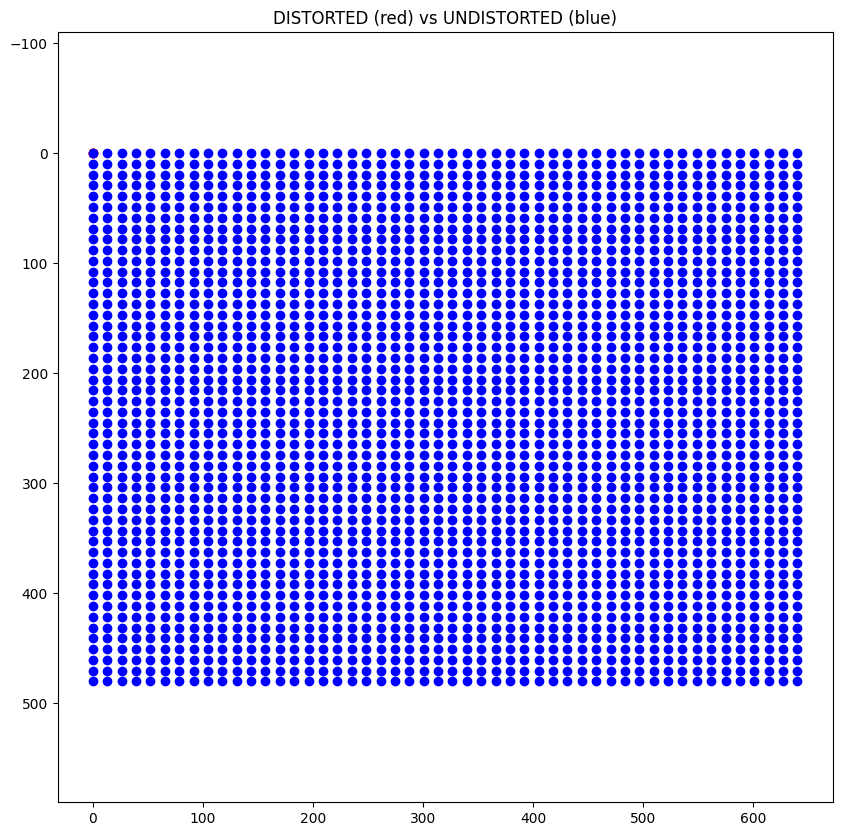

In [57]:
nx, ny = (50, 50)
x = np.linspace(0, 640, nx)
y = np.linspace(0, 480, ny)
xv, yv = np.meshgrid(x, y)
undistorted = np.array([[xv],[yv]], dtype = np.float64)
distorted = np.zeros_like(distorted)

# Compute the 'distorted' similarly to the previous assignment
# ...


# Prepare figure
fig = plt.figure()
ax = fig.gca()

# Plot points
ax.set_title('DISTORTED (red) vs UNDISTORTED (blue)')
ax.scatter(distorted[0,:], distorted[1,:], color = "red" )
ax.scatter(undistorted[0,:], undistorted[1,:], color = "blue" )
ax.axis('equal')
ax.invert_yaxis() # to make the plot show the 'y' axis downwards
fig.show();

#### **<font color=red><b>Expected output</b></font>**
<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/ch9_a1_result.png" width="700">$\\[5pt]$
</center>

## **9.1.2 Camera calibration**

The process of camera calibration implies determining a certain matrix $\mathbf{P}_{3\times4}$, which allows to compute the projection $\bf{m}' = [u\ v]^\texttt{T}$ on the image (in pixels) of any world point $\bf{M} = [X\ Y\ Z]^\texttt{T}$ in space:

$$\lambda\bf{\tilde{m}'}= \begin{bmatrix} \lambda u \\ \lambda v \\ \lambda \end{bmatrix} = \bf{P\tilde{M}} = \begin{bmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \end{bmatrix} \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} \\[30pt]$$

$$u= \frac{p_{11}X + p_{12}Y + p_{13}Z + p_{14}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}} \qquad \qquad v= \frac{p_{21}X + p_{22}Y + p_{23}Z + p_{24}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}$$

If you recall from the last notebook, this matrix includes both the calibration matrix $\mathbf{K}$ and the homogeneous transformation between the `CAMERA` and the `WORLD` reference systems:

$$\bf{P = K[R\ t]}\\[10pt]$$

But we want to **explicitly compute** these two elements separately, that is:

- the **camera pose** $(\mathbf{R}, \mathbf{t})$, which includes **6 extrinsic parameters** ($t_x,\ t_y,\ t_z,\ \text{yaw},\ \text{pitch},\ \text{roll}$):$\\[5pt]$

$$\bf{[R\ t]} = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x\\ r_{21} & r_{22} & r_{23} & t_y\\ r_{31} & r_{32} & r_{33} & t_z \end{bmatrix}\\[10pt]$$

- the **camera intrinsic parameters** ($f,\ k_x,\ k_y,\ u_0,\ v_0$):$\\[5pt]$

$$K = \begin{bmatrix} fk_x & 0 & u_0\\ 0 & fk_y & v_0 \\ 0 & 0 & 1 \end{bmatrix}\\[10pt]$$

Aditionally, we want to determine **two radial distortion parameters** ($k_1, \ k_2$):$\\[5pt]$

$$\begin{eqnarray}
u_u & \approx & u_0 + \frac{u_d - u_0}{1 + k_1 r^2 + k_2 r^4}\\ v_u & \approx & v_0 + \frac{v_d - v_0}{1 + k_1 r^2 + k_2 r^4}
\end{eqnarray}$$

However, since $(\mathbf{R}, \mathbf{t})$ change as the camera moves, camera calibration generally refers to computing the matrix $\mathbf{K}$, and the distortion parameters $(k_1,k_2)$.

### **General procedure for calibration**

**$\rightarrow$ Step 1. Get a set of known 3D points** $\mathbf{M}_i$ (the more the better):

To get a set of 3D points $\mathbf{M}_i$, a **calibration pattern** is employed. This pattern should be easily identificable on the image (typically a chessboard is employed), and the 3D points must not be in a single plane (several planes are needed).$\\[8pt]$

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch9/insert/pattern.png" width="600"/>$\\[5pt]$
</center>

**$\rightarrow$ Step 2. Provide their projections on the image** $\mathbf{m}_i$ (in pixels):

For this, we first detect the corners of the squares in the pattern (e.g. using the Harris detector). Then, we set the pairs ($\mathbf{M}_i,\ \mathbf{m}_i$) based on the 2D ordered list of corners detected (the number of columns and rows of the patterns is known beforehand).$\\[8pt]$

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch9/insert/2dPattern.png" width="300"/>$\\[5pt]$
</center>

**$\rightarrow$ Step 3. Apply the camera model to estimate the parameters** $\mathbf{K},\ \mathbf{R},\ \mathbf{t}$ that best solve for the matches between the corresponding pairs ($\mathbf{M}_i,\ \mathbf{m}_i$)

This is the more complex step and there exist many alternatives, being the most popular:

- The Direct Linear Transformation (DLT)
- The Zang's method

## **9.1.3 Calibration Coding**

Now we are going to use **openCV for calibrating our smartphone camera** (or the examples provided in `/images/calibration` if you prefer). When we calibrate a camera, the distortion parameters of the camera are also determined. With them, it is possible to remove the radial distortion of camera images (usually for smartphone cameras is barely unnoticeable, but you can use a sport camera if you have one).

Fortunately for us **OpenCV already defines a calibration method** [cv2.calibrateCamera](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d), which implements a **variant of the Zhang's method**. But first, as explained above, we need a **calibration pattern** with the picture of the checkerboard. In the classroom it will be provided to you but you can always print [one](https://www.google.com/search?q=camera+calibration+pattern&tbm=isch&ved=2ahUKEwi56NbFsqTpAhWO1uAKHXlVAIAQ2-cCegQIABAA&oq=camera+calibration+pattern&gs_lcp=CgNpbWcQAzICCAAyBggAEAgQHjIGCAAQCBAeMgQIABAYOgQIIxAnOgQIABBDUMIyWMdTYP5UaAJwAHgAgAFbiAGuEJIBAjI4mAEAoAEBqgELZ3dzLXdpei1pbWc&sclient=img&ei=nGG1XrmqPI6tgwf5qoGACA&bih=951&biw=1853&client=ubuntu&hs=qxl&hl=en) for calibrating your camera at home.

Let's start!

1. Move either the calibration pattern or the camera to capture a set of **several images of the pattern** from different perspectives.

2. Then, we will have to **detect the corners** (e.g. using the Harris corner detector) of all images. Fortunately, openCV defines a optimized method [cv2.findChessboardCorners](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a), which automatically detects the corners of the pattern. 

3. These corners will **have to be matched with the pixels coordinates without perspective** for calculating the homographies (remember when you matched the points of the football field to the corners of a rectangle?). As an example, if we detect the second corner of the third column in the pattern, we will have to match the pixel detected by `cv2.findChessboardCorners` with a multiple of $(1,2)$. 

4. Provide the **mapping of the corners** of the pattern images as the input of the `cv2.calibrateCamera` method, which **directly returns the intrinsic parameters and the radial and tangential distortion parameters!**.

5. **Once we have the intrinsic parameters** we will call the [cv2.undistort](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d) method, which implements an **iterative algorithm** to remove the distortion of the image by calculating the normalized original point coordinates from the normalized distorted point coordinates (*normalized* means that the coordinates do not depend on the camera matrix). 

**Well, let's give it a go, but step by step!**


### **<font color="green">ASSIGNMENT #2a</font>** (GIVEN)

First, we are going to **define the matrix containing the object points**, which is a matrix with size $(\text{corners}\times3)$. This matrix contains the ideal coordinates of the corners in a non-perspective image of the pattern (necessary for obtaining the homographies). **This will be our ideal image of the pattern**.

As the corners will be detected using `cv2.findChessboardCorners`, the order of the corners is fixed, and should be like this:

$$[(0,0,0),\ (1,0,0),\ (2,0,0),\ \ldots ,\ (\text{n_cols}, \text{n_rows},0)]$$

Take into account that the corners we will detect are the **inner corners of the pattern**. 

So, our first task is to build a matrix like this (the third column is mandatory):

In [58]:
# ASSIGNMENT #2a
# Write your code here!
# Pattern corners
import numpy
n_cols, n_rows = 12, 13
objp = np.zeros((n_cols*n_rows,3), dtype= np.float32)

for y in range(n_rows):
  for x in range(n_cols):
    objp[y*n_cols+x,0] = x
    objp[y*n_cols+x,1] = y

print(objp)

[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 2.  0.  0.]
 [ 3.  0.  0.]
 [ 4.  0.  0.]
 [ 5.  0.  0.]
 [ 6.  0.  0.]
 [ 7.  0.  0.]
 [ 8.  0.  0.]
 [ 9.  0.  0.]
 [10.  0.  0.]
 [11.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]
 [ 2.  1.  0.]
 [ 3.  1.  0.]
 [ 4.  1.  0.]
 [ 5.  1.  0.]
 [ 6.  1.  0.]
 [ 7.  1.  0.]
 [ 8.  1.  0.]
 [ 9.  1.  0.]
 [10.  1.  0.]
 [11.  1.  0.]
 [ 0.  2.  0.]
 [ 1.  2.  0.]
 [ 2.  2.  0.]
 [ 3.  2.  0.]
 [ 4.  2.  0.]
 [ 5.  2.  0.]
 [ 6.  2.  0.]
 [ 7.  2.  0.]
 [ 8.  2.  0.]
 [ 9.  2.  0.]
 [10.  2.  0.]
 [11.  2.  0.]
 [ 0.  3.  0.]
 [ 1.  3.  0.]
 [ 2.  3.  0.]
 [ 3.  3.  0.]
 [ 4.  3.  0.]
 [ 5.  3.  0.]
 [ 6.  3.  0.]
 [ 7.  3.  0.]
 [ 8.  3.  0.]
 [ 9.  3.  0.]
 [10.  3.  0.]
 [11.  3.  0.]
 [ 0.  4.  0.]
 [ 1.  4.  0.]
 [ 2.  4.  0.]
 [ 3.  4.  0.]
 [ 4.  4.  0.]
 [ 5.  4.  0.]
 [ 6.  4.  0.]
 [ 7.  4.  0.]
 [ 8.  4.  0.]
 [ 9.  4.  0.]
 [10.  4.  0.]
 [11.  4.  0.]
 [ 0.  5.  0.]
 [ 1.  5.  0.]
 [ 2.  5.  0.]
 [ 3.  5.  0.]
 [ 4.  5.  0.]
 [ 5.  5.  0.]
 [ 6.  5. 

#### **<font color=red><b>Expected output</b></font>**
(this is for a $n_{cols} = 12, n_{rows} = 13$ corners pattern, adapt these numbers to your own pattern)

    [[ 0.  0.  0.]
     [ 1.  0.  0.]
     [ 2.  0.  0.]
     [ 3.  0.  0.]
           .
           .
           .
     [ 8. 12.  0.]
     [ 9. 12.  0.]
     [10. 12.  0.]
     [11. 12.  0.]]

### **<font color="green">ASSIGNMENT #2b</font>**

Now, we will **detect the corners of all the images** contained in `./images/calibration/` (or your own images, if you prefer) using the `findChessboardCorners` method, which takes a grayscale image as input as well as the number of rows and columns of corners that our pattern has. It returns a boolean value, which indicates whether the pattern was found in the image or not. 

> <font color="orange">**Note:** If you use your own pictures, **do not compress them**, as it happens, for instance, when they are shared via WhatsApp.</font>

If the corners are found correctly, we will establish a map between the detected coordinates and the ideal ones, as that is the input that the `cv2.calibrateCamera` method takes. Besides, if you want to check that the corners have been detected in a correct way, you can draw them on the image using [drawChessboardCorners](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022) and, then, show the image.

So, in summary, this is what you need to do:
- **define two lists**, one for storing the detected corners and the other one for storing the "ideal" coordinates of the points in the pattern (i.e. that matrix you created in the **assignment 2a**). *Note: each element of this list will be also a list with the points corresponding to each valid image.*
- for each image, **try to find the corners** of the checkerboard using `findChessboardCorners` and, if the result is valid, add it to the first list. Note that this process will not be always succesfull because the pattern might not be clearly visible!, hence checking the result of the method.
- add a copy of the **ideal corners matrix** you created before to the second list. This way we have a duple "detected points" $\rightarrow$ "ideal points" for the homography computation for each image where the pattern has correctly been detected.

In [65]:
# ASSIGNMENT 2b
# Write your code here!
# Read images names
images  = './images/calibration/' + 'image'
objpoints  = []
imgpoints  = []
ideal_corners = []
size=(n_cols, n_rows)

# Find corners in each pattern
for file in range(15):
    img = cv2.imread(images + str(file+1) + '.jpg', 0)
    imgpoints.append(img)
    ret, det_corner = cv2.findChessboardCorners(img, size)
    if ret:
        objpoints.append(det_corner)
        ideal_corners.append(ObjectPoints)



error: ignored

### **<font color="green">ASSIGNMENT #2c</font>**

Now, we will use both lists obtained in above exercise for the [cv2.calibrateCamera](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d) method, which **returns the intrinsic, extrinsic and distortion parameters** of the camera, as well as the rotation and translation parameters for all the views! This method also takes as input the size of the images (used only to initialize the intrinsic camera matrix).

In [66]:
# ASSIGNMENT #2c
# Write your code here!
# Apply Zang's method for calibrate the camera using OpenCV

ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(ideal_corners, objpoints, (img.shape[0], img.shape[1]), None, None)
print(cameraMatrix)
print(distCoeffs)

AttributeError: ignored

#### **<font color=red><b>Expected output</b></font>**
Intrinsic parameters:
$[848.102, 0, 521.756]\\
 [ 0, 847.5, 299.628]\\
 [ 0, 0, 1 ]$

Distortion parameters:
$[ 0.227, -0.966, -0.001, -0.001, 0.882]$

> <font color="orange">**Note:** Calibration is a process very sensitive to noise, so you might end up with slightly different figures here.</font>

#### <font color="blue"><b>Discussion #1</b></font>
**Answer the following questions:**
- What **type of radial distortion** has the employed camera?

    <font color=blue><b>Barrel distortion</b></font>
- Identify your **camera intrinsic parameters** in the camera matrix:
   
    <font color=blue><b>Your answer here!</b></font>


### **<font color="green">ASSIGNMENT #2d</font>**

Finally, now that we have the camera matrix and the distortion parameters, we are going to use [cv2.undistort](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d) to remove the image distortion. This method takes the image as input as well as the camera matrix and the distortion parameters. Then, it **removes both the tangential and radial distortions** of the image and returns it.

**Read one of the images used for calibration and display both the original and the undistorted image in a $1\times2$ subplot**. 

> <font color="orange">**Note:** If the distortion is low, the change might be almost unnoticeable.</font>

In [67]:
# ASSIGNMENT #2d
# Write your code here!

undistorted_image = cv2.undistort(images[1], cameraMatrix, distCoeffs)
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(images[1], cmap='gray')

plt.subplot(1,2,2)
plt.title('Undistorted image')
plt.imshow(undistorted_image, cmap='gray')

NameError: ignored

## **Conclusion**

Great work! You better save the intrinsic values of your camera because you will need them for the next chapter!

In this notebook, you have learnt:

- different types of distortions and how to remove them,
- how to calibrate any camera, using the OpenCV's implementation of the Zhang's method.
